# Brain stroke data exploration and stroke chances evaluation 
Konrad Markowski 13-08-2022

data from https://www.kaggle.com/datasets/jillanisofttech/brain-stroke-dataset

In [1]:
#loading libraries used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

## About data

Data contains 11 columns, of which only 3 contain continuous data (age, bmi, avg_glucose_level), the rest of the columns contains categorical data either in the boolean form (0 or 1), or in a form of a string. 
The origin of data, that is when or where the data was made is unknown. 

In [380]:
data = pd.read_csv('./data/brain_stroke.csv')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Data has 4733 entries about people that did not have a stroke and 248 people that had a stroke, which signals right away that given dataset has strongly unbalanced data.

In [381]:
data.groupby('stroke')['age'].count()

stroke
0    4733
1     248
Name: age, dtype: int64

## Data cleaning 

Data contains 673 children and only 2 cases of stroke among them, because of that they are filtered out from the dataset.

Also data containing unknown smoking status is filtered out because of a bias that smoking should have negative impact on health, otherwise this information might be hard to use.

This leaves dataset with 3211 no stroke samples and 201 stroke samples.

In [386]:
#data.query("work_type == 'children'")['age'].count()
#data.query("work_type == 'children' & stroke == 1")['age'].count()

In [388]:
#filtering out data containing children 
data = data.query("work_type != 'children'")
data = data.query("smoking_status != 'Unknown'") # this also filters out 47 cases of patients that had a stroke (out of about 250 in total stroke cases)
data.groupby('stroke')['age'].count()

stroke
0    3211
1     201
Name: age, dtype: int64

## Data visualization 

### Categorical data

In order to properly visualize and interpret categorical data, data was normalized and therefore scaled in each category. 

Data was divided by gender as it might reveal if there are any differences between male or female. 

To give better idea how data was normalized, the results for the category 'ever_married' are displayed below. 


In [5]:
p = data.groupby(['ever_married','gender'])['stroke'].value_counts(normalize=True).mul(100).reset_index(name='percentage')
p

,ever_married,gender,stroke,percentage
0,No,Female,0,96.875000
1,No,Female,1,3.125000
2,No,Male,0,97.826087
3,No,Male,1,2.173913
4,Yes,Female,0,93.690852
5,Yes,Female,1,6.309148
6,Yes,Male,0,92.530345
7,Yes,Male,1,7.469655


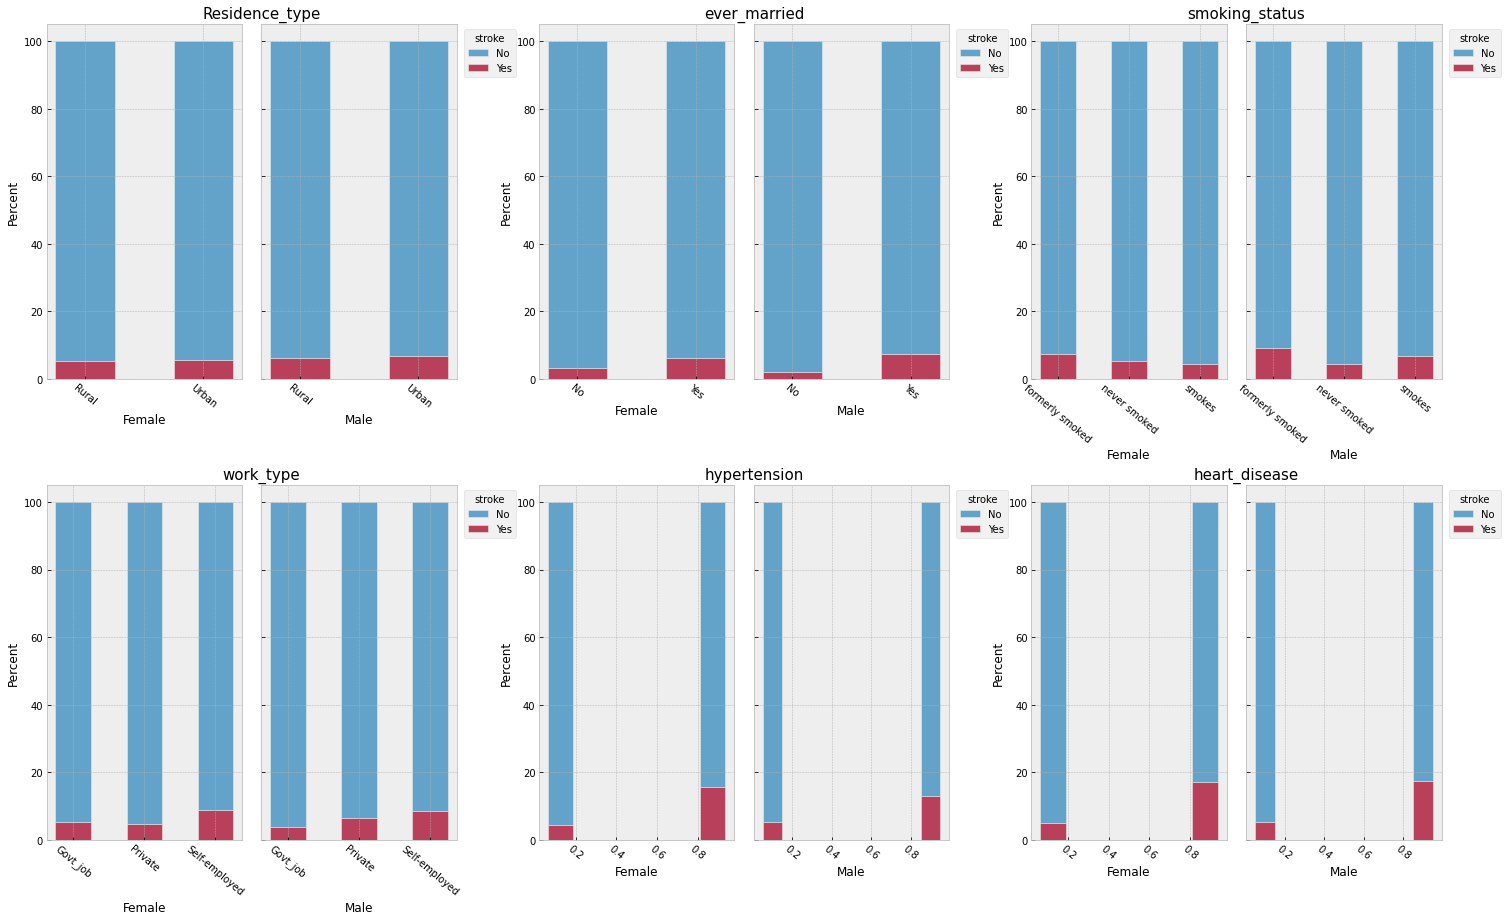

In [6]:
def makePlot(col_names):

    fig = plt.figure(figsize=(25, 15))
    outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.3)

    for i in range(6):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        
        p = data.groupby([col_names[i],'gender'])['stroke'].value_counts(normalize=True).mul(100).reset_index(name='percentage')
        d = [ p.query("gender == 'Female'"),p.query("gender == 'Male'")]

        for j in range(2):

            ax = plt.Subplot(fig, inner[j])
    
            if j == 0:
                subplot = sns.histplot(x = col_names[i] , hue = 'stroke',weights= 'percentage', multiple = 'stack',data=d[j],shrink = 0.5, ax=ax,bins=4, legend=False)
                subplot.set_ylabel("Percent")
                subplot.set_title(col_names[i], size=15, x=1.1)
                subplot.set_xlabel("Female")
                
            else:
                subplot = sns.histplot(x = col_names[i] , hue = 'stroke',weights= 'percentage', multiple = 'stack',data=d[j],shrink = 0.5, ax=ax,bins=5)
                subplot.set_ylabel("")
                subplot.set(yticklabels=[])
                subplot.legend(handles=subplot.legend_.legendHandles, labels=["No","Yes"],
                    title=subplot.legend_.get_title().get_text(),bbox_to_anchor=(1.01, 1), loc='upper left')
                subplot.set_xlabel("Male")
            
            subplot.tick_params(axis='x', rotation=-40)

            fig.add_subplot(ax)

categorical_var_col_names = ["Residence_type","ever_married","smoking_status","work_type","hypertension","heart_disease"]
makePlot(categorical_var_col_names)    

Note that for hypertension and heart_disease the values are 0 and 1 which corresponds to 'no' or 'yes' in both cases.

Looking at the plotted categorical data shows that residence type doesn't seem to have any influence on having a stroke. Because of that this column will be dropped later. 

For hypertension and heart disease we can see that it increases chances of having a stroke.

As for other categories there are small differences, hence it is hard to infer how much of a influence they might have on chances of a stroke. 

### Continuous data

For continuous data there is no need for scaling

In [7]:
data.groupby("stroke").aggregate("mean")

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,48.653690,0.114295,0.058549,107.347253,29.917814
1,68.283582,0.308458,0.194030,133.898109,30.398010


Note that in the table above hypertension and heart_disease columns shows how many % of a given group has a given feature, other columns shows mean value in the group.

Also because there is no detailed information about the glucose level measurement, it will be assumed that values below 100 are normal glucose levels and anything above is 'not normal'.

Interestingly both groups have almost identical bmi level which in both cases is the obesity level.

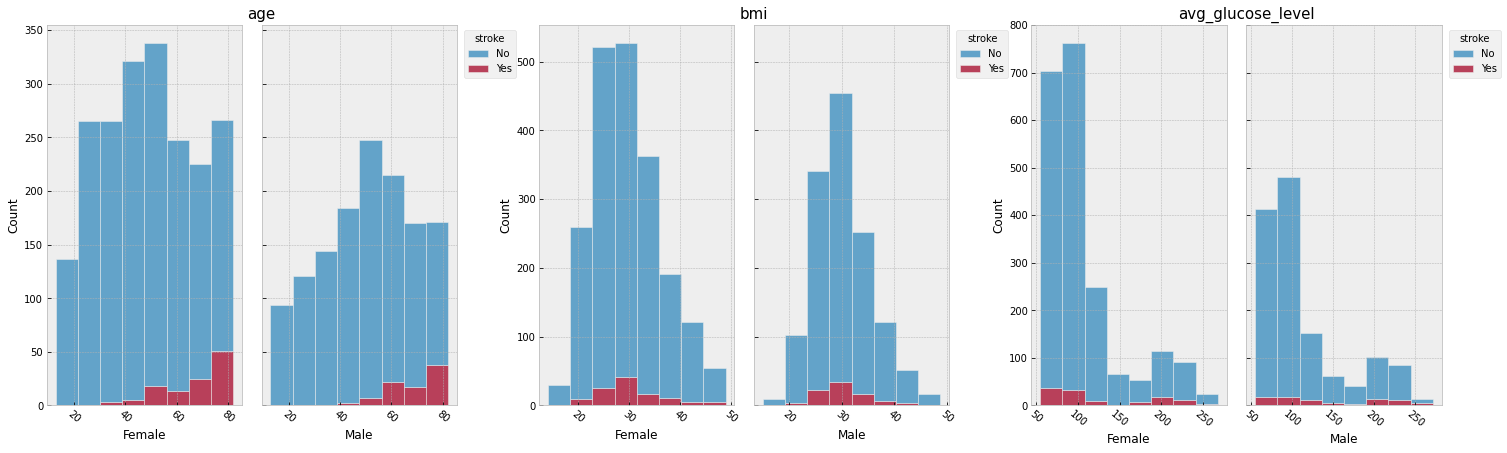

In [8]:
def makePlot2(col_names):

    fig = plt.figure(figsize=(25, 7))
    outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.3)

    d = [data.query("gender == 'Female'"),data.query("gender == 'Male'")]
    
    for i in range(3):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        yticks = None
        ylim = None
        for j in range(2):

            ax = plt.Subplot(fig, inner[j])
            
            if j == 0:
                subplot = sns.histplot(x = col_names[i] , hue = 'stroke', multiple = 'stack',data=d[j], ax=ax,bins=8, legend=False)
                subplot.set_ylabel("Count")
                subplot.set_title(col_names[i], size=15, x=1.1)
                subplot.set_xlabel("Female") 
                yticks = subplot.get_yticks().tolist()
                ylim = subplot.get_ylim()

            else:
                subplot = sns.histplot(x = col_names[i] , hue = 'stroke', multiple = 'stack',data=d[j], ax=ax,bins=8)
                subplot.set_ylabel("")
                subplot.set_yticks(yticks)
                subplot.set_yticklabels([])
                subplot.set_ylim(ylim)
                subplot.legend(handles=subplot.legend_.legendHandles, labels=["No","Yes"],
                    title=subplot.legend_.get_title().get_text(),bbox_to_anchor=(1.01, 1), loc='upper left')
                subplot.set_xlabel("Male")
            
            subplot.tick_params(axis='x', rotation=-40)
            
            fig.add_subplot(ax)

continuos_var_col_names = ['age','bmi','avg_glucose_level']
makePlot2(continuos_var_col_names)    

## Creating machine learning model

Logistic regression model seems to fit the data and is easy to interpret, therefore it will be used in this project. 

The goal for creating this model is to evaluate if given sample is similar to the samples that had a stroke, which might be useful information to evaluate if given sample has higher risk of having a stroke. 

### Data preparation

Creating dummy variables for categorical data.

In [10]:
data.drop(columns="Residence_type", inplace=True) # dropping residence type column as it doesn't seem to have any influence on having a stroke
data_dummies = pd.get_dummies(data) # creating dummy variables for categorical data
data_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,1,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,1,0,1,0,0


Splitting data into features and target.

In [373]:
features_names = [x for x in data_dummies.keys() if x != 'stroke']
features = data_dummies.loc[:,features_names]

X = features.values
y = data_dummies["stroke"].values

# check if sizes are the same
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (3412, 15) y.shape: (3412,)


### Creating and evaluating model

Applying the data into the model, because of the high unbalance between count of stroke and no stroke cases, the class_weight argument is used. 

Otherwise model would always assume 'no stroke' which is obviously wrong. 

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

logreg = LogisticRegression(max_iter=1000,C=1000,class_weight='balanced',random_state=10)
logreg.fit(X_train, y_train)

print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))
pred_logreg = logreg.predict(X_test)

Test score: 0.72


In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_logreg,target_names=["no stroke", "stroke"]))


              precision    recall  f1-score   support

   no stroke       0.99      0.71      0.83       797
      stroke       0.18      0.91      0.30        56

    accuracy                           0.72       853
   macro avg       0.59      0.81      0.56       853
weighted avg       0.94      0.72      0.79       853



Text(40.82000000000001, 0.5, 'true value')

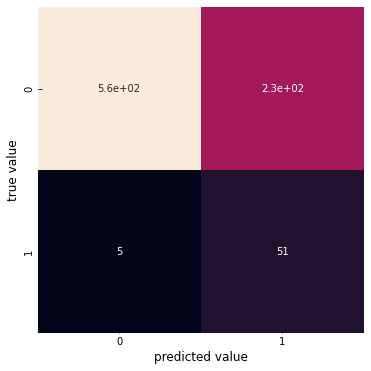

In [374]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, pred_logreg)

plt.figure(figsize=(6,6))
sns.heatmap(confusion, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

Results on test data shows that model assumed about 230 cases as false-positive, which doesn't seem good but maybe these samples had similar feature values as positive cases which mean these samples might have higher risk of having a stroke. Other than that model assumed most true positive cases as positive.

### Model coefficient interpretation

Text(0, 0.5, 'Coefficient magnitude')

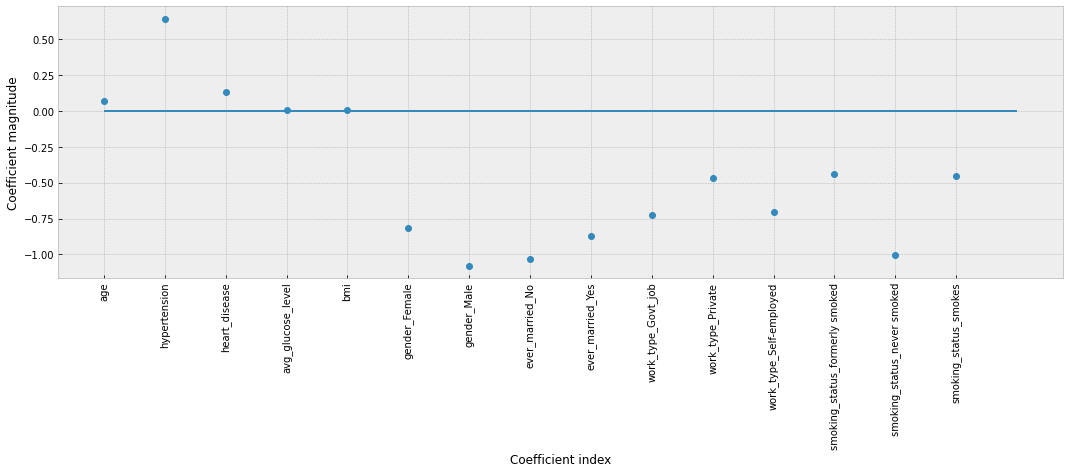

In [375]:
plt.figure(figsize=(18,5))
plt.plot(logreg.coef_.T, 'o')
plt.xticks(range(len(features_names)), features_names, rotation=90)
plt.hlines(0, 0, (len(features_names)))
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")

Looking on the coefficients magnitude we can see that glucose level and bmi doesn't seem to be much influenced by the model.

Interpretation of categorical dummy variables should be done in the groups of their categories they come from and the differences are really small except for the smoking, where never smoking i weighted significantly more than smoking and formerly smoking.

### Model probabilistic interpretation

As noted earlier, high false-positive result might be caused by correct model evaluation that a given sample has similar results as the positive cases. In order to prove that tested data will be analyzed in terms of probability given by the model.

In [355]:
result_df = pd.DataFrame(logreg.predict_proba(X_test), columns=['no_stroke_proba', 'stroke_proba'] )
test_df = pd.DataFrame(X_test,columns=features_names)
result_df = pd.concat([result_df,test_df],axis=1)

Firstly test data was divided into groups with at least 50% certainty for belonging to either category ('High risk for a stroke' or 'Low risk for a stroke'). 

In this case all test data is taken into account, and values except for age, avg_glucose_level and bmi (which are mean values for the group) are representing how much of the group has a given feature (vales from 0 to 1, it is equivalent to percent).


In [392]:
result_df["at_least_50%_certain_that"] = np.nan
result_df["at_least_50%_certain_that"]=result_df["at_least_50%_certain_that"].mask(result_df["stroke_proba"] >= 0.5, "High risk for a stroke").mask(result_df["no_stroke_proba"] >= 0.5, "Low risk for a stroke")
result_df.groupby("at_least_50%_certain_that").mean().round(2).drop(['no_stroke_proba','stroke_proba'],axis=1).transpose()

at_least_50%_certain_that,High risk for a stroke,Low risk for a stroke
age,70.24,39.78
hypertension,0.29,0.04
heart_disease,0.15,0.02
avg_glucose_level,130.23,98.50
bmi,30.41,30.10
gender_Female,0.61,0.62
gender_Male,0.39,0.38
ever_married_No,0.10,0.30
ever_married_Yes,0.90,0.70
work_type_Govt_job,0.09,0.18


We can expect that if we increase minimum certainty of the model, mean age and glucose levels for 'Low risk for a stroke' will decrease and for 'High risk for a stroke' -  increase.

In [393]:
result_df["at_least_70%_certain_that"] = np.nan
result_df["at_least_70%_certain_that"]=result_df["at_least_70%_certain_that"].mask(result_df["stroke_proba"] >= 0.7, "High risk for a stroke").mask(result_df["no_stroke_proba"] >= 0.7, "Low risk for a stroke")
result_df.groupby("at_least_70%_certain_that").mean().round(2).drop(['no_stroke_proba','stroke_proba'],axis=1).transpose()

at_least_70%_certain_that,High risk for a stroke,Low risk for a stroke
age,74.81,34.07
hypertension,0.44,0.02
heart_disease,0.23,0.00
avg_glucose_level,147.08,95.58
bmi,30.54,29.41
gender_Female,0.62,0.61
gender_Male,0.38,0.39
ever_married_No,0.09,0.38
ever_married_Yes,0.91,0.62
work_type_Govt_job,0.07,0.17


We can also notice that smoking_status_never smoked value increases for 'Low risk for a stroke' with increase of certainty, and for high risk -  decreases.

In [394]:
result_df["at_least_90%_certain_that"] = np.nan
result_df["at_least_90%_certain_that"]=result_df["at_least_90%_certain_that"].mask(result_df["stroke_proba"] >= 0.9, "High risk for a stroke").mask(result_df["no_stroke_proba"] >= 0.9, "Low risk for a stroke")
result_df.groupby("at_least_90%_certain_that").mean().round(2).drop(['no_stroke_proba','stroke_proba'],axis=1).transpose()

at_least_90%_certain_that,High risk for a stroke,Low risk for a stroke
age,79.80,24.46
hypertension,1.00,0.00
heart_disease,0.20,0.00
avg_glucose_level,170.43,90.57
bmi,30.28,27.73
gender_Female,0.40,0.60
gender_Male,0.60,0.40
ever_married_No,0.00,0.72
ever_married_Yes,1.00,0.28
work_type_Govt_job,0.00,0.13


We can see that models seems to be correctly evaluating if the given sample should be classified as high or low risk. Hence, high false-positive rate is a result of samples that have similar values as positive cases yet they were not having a stroke.
Because goal for this model was to vaguely evaluate risk of having a stroke this is not concerning and results are confirming intuition and common knowledge such as increasing chance for a stroke with age.

## Conclusion

Data exploration and model did not bring any new insight. They confirmed known facts and intuition which is good but a bit disappointing, as the categorical features like being married, work type or residence type didn't seem to have any impact on the results.
Because of data size and unbalance there could be a problem with creating a good model but results seem to be very good, yet bigger size of positive samples would be welcomed.

Because bmi in both groups ('stroke' and 'no stroke') was almost identical, this feature also did not play much of a role in the analysis but it might be worth to note that with increase of the model certainty, there was a small drop in the bmi for the 'Low risk for a stroke' category.

